# **Automatidata project**

*You are a data professional in a data analytics firm called Automatidata. Their client, the New York City Taxi & Limousine Commission (New York City TLC), was impressed with the work you have done and has requested that you build a machine learning model to predict if a customer will not leave a tip. They want to use the model in an app that will alert taxi drivers to customers who are unlikely to tip, since drivers depend on tips.*

### Use tree-based modeling techniques to predict on a binary target class 

<br/>   

**The purpose** of this model is to find ways to generate more revenue for taxi cab drivers.  
  
**The goal** of this model is to predict whether or not a customer is a generous tipper.  
<br/>  

*This activity has three parts:*

**Part 1:** Ethical considerations 

**Part 2:** Feature engineering

**Part 3:** Modeling


# Build a machine learning model


1.   **What is the business question?**

Predict if a customer will **not** leave a tip.

2.   **What are the ethical implications of the model? What are the consequences of the model making errors?**

  *   False negative: Drivers who didn't receive tips will probably be upset that the app told them a customer would leave a tip. If it happened often, drivers might not trust the app.
  
  *   False positive: Drivers are unlikely to pick up people who are predicted to not leave tips. Customers will have difficulty finding a taxi that will pick them up, and might get angry at the taxi company  
 
 Even when the model is correct, people who can't afford to tip will find it more difficult to get taxis, which limits the accessibility of taxi service to those who pay extra.
  
3.   **Do the benefits of such a model outweigh the potential problems?**
  
  It's not good to disincentivize drivers from picking up customers. It could also cause a customer backlash. The problems seem to outweigh the benefits
  
4.   **Would we proceed with the request to build this model?**

 Ethically no. Effectively limiting equal access to taxis is ethically problematic, and carries a lot of risk. 
 
5.   **Can the objective be modified to make it less problematic?**
 
We can build a model that predicts **the most generous customers**. This could accomplish the goal of helping taxi drivers increase their earnings from tips while preventing the wrongful exclusion of certain people from using taxis.

So, we will modify the modeling objective, instead of predicting people who won't tip at all, we will  predict people who are particularly generous&mdash; **those who will tip 20% or more**. Consider the following questions:

1.  **What features do we need to make this prediction?**

Ideally, we'd have behavioral history for each customer, so we could know how much they tipped on previous taxi rides. We'd also want times, dates, and locations of both pickups and dropoffs, estimated fares, and payment method.


2.  **What would be the target variable?**  

The target variable would be a binary variable (1 or 0) that indicates whether or not the customer is expected to tip ≥ 20%.

3.  **What metric should we use to evaluate your model? Do you have enough information to decide this now?**

This is a supervised learning, classification task. We could use accuracy, precision, recall, F-score, area under the ROC curve, or a number of other metrics. However, we don't have enough information at this time to know which are most appropriate. We need to know the class balance of the target variable.


### **Task 1. Imports and data loading**

Import packages and libraries needed to build and evaluate **random forest** and **XGBoost** classification models.

In [98]:
# Import packages and libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# This is the function that helps plot feature importance 
from xgboost import plot_importance

In [100]:
# This lets us see all of the columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)

We will start by reading in the data. There are two dataframes: one containing the original data, the other containing the mean durations, mean distances, and predicted fares from the linear regresssion project calledp `nyc_preds_means.csv`.

In [103]:
# Load dataset into dataframe
df0 = pd.read_csv('../Data/2017_Yellow_Taxi_Trip_Data.csv')

# Import predicted fares and mean distance and duration from the linear regression project.
nyc_preds_means = pd.read_csv('../Data/nyc_preds_means.csv')

In [105]:
# Inspect the first few rows of df0
df0.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80


In [107]:
# Inspect the first few rows of `nyc_preds_means`
nyc_preds_means.head()

,mean_duration,mean_distance,predicted_fare
0,22.847222,3.521667,16.434245
1,24.470370,3.108889,16.052218
2,7.250000,0.881429,7.053706
3,30.250000,3.700000,18.731650
4,14.616667,4.435000,15.845642


#### Join the two dataframes

In [110]:
# Merge datasets
df0 = pd.concat([df0,nyc_preds_means],axis=1) 
df0.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,22.847222,3.521667,16.434245
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,24.470370,3.108889,16.052218
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.250000,0.881429,7.053706
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,3.700000,18.731650
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80,14.616667,4.435000,15.845642


### **Task 2. Feature engineering**

Let's call `info()` on the new combined dataframe.

In [113]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             22699 non-null  int64  
 1   VendorID               22699 non-null  int64  
 2   tpep_pickup_datetime   22699 non-null  object 
 3   tpep_dropoff_datetime  22699 non-null  object 
 4   passenger_count        22699 non-null  int64  
 5   trip_distance          22699 non-null  float64
 6   RatecodeID             22699 non-null  int64  
 7   store_and_fwd_flag     22699 non-null  object 
 8   PULocationID           22699 non-null  int64  
 9   DOLocationID           22699 non-null  int64  
 10  payment_type           22699 non-null  int64  
 11  fare_amount            22699 non-null  float64
 12  extra                  22699 non-null  float64
 13  mta_tax                22699 non-null  float64
 14  tip_amount             22699 non-null  float64
 15  to

From a previous EDA we learned that customers who pay cash generally have a tip amount of $0. To meet the modeling objective, we will need to sample the data to select only the customers who pay with credit card. 

Copy `df0` and assign the result to a variable called `df1`. Then, use a Boolean mask to filter `df1` so it contains only customers who paid with credit card.

In [116]:
# Subset the data to isolate only customers who paid by credit card
df1 = df0[df0['payment_type']==1]

##### **Target**

There isn't a column that indicates tip percent, which is what we need to create the target variable. We have to engineer it. 

Let's add a `tip_percent` column to the dataframe by performing the following calculation:  
<br/>  


$$tip\ percent = \frac{tip\ amount}{total\ amount - tip\ amount}$$  

and round the result to three places beyond the decimal. 

In [121]:
# Create tip % col
df1.loc[:,'tip_percent'] = round(df1['tip_amount'] / (df1['total_amount'] - df1['tip_amount']), 3)

Now let's create another column called `generous`. This will be the target variable. The column should be a binary indicator of whether or not a customer tipped ≥ 20% (0=no, 1=yes).

In [126]:
df1.loc[:,'generous'] = (df1['tip_percent'] >= 0.2)
df1.loc[:,'generous'] = df1['generous'].astype(int)

#### Create day column

Next, we are going to be working with the pickup and dropoff columns.

Let's convert the `tpep_pickup_datetime` and `tpep_dropoff_datetime` columns to datetime.

In [130]:
# Convert pickup and dropoff cols to datetime
df1['tpep_pickup_datetime'] = pd.to_datetime(df1['tpep_pickup_datetime'],format='%m/%d/%Y %I:%M:%S %p')
df1['tpep_dropoff_datetime'] = pd.to_datetime(df1['tpep_dropoff_datetime'], format='%m/%d/%Y %I:%M:%S %p')

/var/folders/wk/bcw245551s5g_nbp73wtjy9c0000gn/T/ipykernel_59985/2740175889.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['tpep_pickup_datetime'] = pd.to_datetime(df1['tpep_pickup_datetime'],format='%m/%d/%Y %I:%M:%S %p')
/var/folders/wk/bcw245551s5g_nbp73wtjy9c0000gn/T/ipykernel_59985/2740175889.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['tpep_dropoff_datetime'] = pd.to_datetime(df1['tpep_dropoff_datetime'], format='%m/%d/%Y %I:%M:%S %p')


We continue by creating a `day` column that contains only the day of the week when each passenger was picked up. Then, convert the values to lowercase.

In [135]:
# Create a 'day' col
df1.loc[:,'day'] = df1['tpep_pickup_datetime'].dt.day_name().str.lower()
#df1.loc[:,'day'] = df1['tpep_pickup_datetime'].dt.day_name().str.lower()

#### Create time of day columns

Next, we will engineer four new columns that represent time of day bins. Each column should contain binary values (0=no, 1=yes) that indicate whether a trip began (picked up) during the following times:

`am_rush` = [06:00&ndash;10:00)  
`daytime` = [10:00&ndash;16:00)  
`pm_rush` = [16:00&ndash;20:00)  
`nighttime` = [20:00&ndash;06:00)  

To do this, let's first create the four columns. For now, each new column should be identical and contain the same information: the hour (only) from the `tpep_pickup_datetime` column.

In [139]:
# Create 'am_rush' col
df1.loc[:,'am_rush'] = df1['tpep_pickup_datetime'].dt.hour

# Create 'daytime' col
df1.loc[:,'daytime'] = df1['tpep_pickup_datetime'].dt.hour

# Create 'pm_rush' col
df1.loc[:,'pm_rush'] = df1['tpep_pickup_datetime'].dt.hour

# Create 'nighttime' col
df1.loc[:,'nighttime'] = df1['tpep_pickup_datetime'].dt.hour

We will need to write four functions to convert each new column to binary (0/1). Begin with `am_rush`. 

In [141]:
# Define 'am_rush()' conversion function [06:00–10:00)
def am_rush(hour):
    if 6 <= hour['am_rush'] < 10:
        val = 1
    else:
        val = 0
    return val

# Define 'daytime()' conversion function [10:00–16:00)
def daytime(hour):
    if 10 <= hour['daytime'] < 16:
        val = 1
    else:
        val = 0
    return val

# Define 'pm_rush()' conversion function [16:00–20:00)
def pm_rush(hour):
    if 16 <= hour['pm_rush'] < 20:
        val = 1
    else:
        val = 0
    return val

# Define 'nighttime()' conversion function [20:00–06:00)
def nighttime(hour):
    if 20 <= hour['nighttime'] < 24:
        val = 1
    elif 0 <= hour['nighttime'] < 6:
        val = 1
    else:
        val = 0
    return val

In [143]:
# Apply 'am_rush' function to the 'am_rush' series
df1.loc[:,'am_rush'] = df1.apply(am_rush, axis=1)

# Apply 'daytime' function to the 'daytime' series
df1.loc[:,'daytime'] = df1.apply(daytime, axis=1)

# Apply 'pm_rush' function to the 'pm_rush' series
df1.loc[:,'pm_rush'] = df1.apply(pm_rush, axis=1)

# Apply 'nighttime' function to the 'nighttime' series
df1.loc[:,'nighttime'] = df1.apply(nighttime, axis=1)

In [144]:
df1['am_rush'].head()

0    1
1    0
2    1
3    0
5    0
Name: am_rush, dtype: int64

#### Create `month` column

Now, we will create a `month` column that contains only the abbreviated name of the month when each passenger was picked up, then convert the result to lowercase.

In [151]:
# Create 'month' col
df1.loc[:,'month'] = df1['tpep_pickup_datetime'].dt.strftime('%b').str.lower()

In [39]:
df1.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare,tip_percent,generous,day,am_rush,daytime,pm_rush,nighttime,month
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,22.847222,3.521667,16.434245,0.200,1,saturday,1,0,0,0,mar
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,24.470370,3.108889,16.052218,0.238,1,tuesday,0,1,0,0,apr
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.250000,0.881429,7.053706,0.199,0,friday,1,0,0,0,dec
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,3.700000,18.731650,0.300,1,sunday,0,1,0,0,may
5,23345809,2,2017-03-25 20:34:11,2017-03-25 20:42:11,6,2.30,1,N,161,236,1,9.0,0.5,0.5,2.06,0.0,0.3,12.36,11.855376,2.052258,10.441351,0.200,1,saturday,0,0,0,1,mar


#### Drop columns

Here, we will drop redundant and irrelevant columns as well as those that would not be available when the model is deployed. This includes information like payment type, trip distance, tip amount, tip percentage, total amount, toll amount, etc. The target variable (`generous`) must remain in the data because it will get isolated as the `y` data for modeling.

In [41]:
# Drop columns
drop_cols = ['Unnamed: 0', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
             'payment_type', 'trip_distance', 'store_and_fwd_flag', 'payment_type',
             'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
             'improvement_surcharge', 'total_amount', 'tip_percent']

df1 = df1.drop(drop_cols, axis=1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15265 entries, 0 to 22698
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   VendorID         15265 non-null  int64  
 1   passenger_count  15265 non-null  int64  
 2   RatecodeID       15265 non-null  int64  
 3   PULocationID     15265 non-null  int64  
 4   DOLocationID     15265 non-null  int64  
 5   mean_duration    15265 non-null  float64
 6   mean_distance    15265 non-null  float64
 7   predicted_fare   15265 non-null  float64
 8   generous         15265 non-null  int64  
 9   day              15265 non-null  object 
 10  am_rush          15265 non-null  int64  
 11  daytime          15265 non-null  int64  
 12  pm_rush          15265 non-null  int64  
 13  nighttime        15265 non-null  int64  
 14  month            15265 non-null  object 
dtypes: float64(3), int64(10), object(2)
memory usage: 1.9+ MB


#### Variable encoding

Many of the columns are categorical and will need to be dummied (converted to binary). Some of these columns are numeric, but they actually encode categorical information, such as `RatecodeID` and the pickup and dropoff locations. To make these columns recognizable to the `get_dummies()` function as categorical variables, we will first need to convert them to `type(str)`. 

In [44]:
# 1. Define list of cols to convert to string
cols_to_str = ['RatecodeID', 'PULocationID', 'DOLocationID', 'VendorID']

# 2. Convert each column to string
for col in cols_to_str:
    df1[col] = df1[col].astype('str')


Now we will convert all the categorical columns to binary.

In [46]:
# Convert categoricals to binary
df2 = pd.get_dummies(df1, drop_first=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15265 entries, 0 to 22698
Columns: 347 entries, passenger_count to month_sep
dtypes: bool(338), float64(3), int64(6)
memory usage: 6.1 MB


##### Evaluation metric

Before modeling, we must decide on an evaluation metric. 

1. Let's examine the class balance of the target variable. 

In [48]:
# Get class balance of 'generous' col
df2['generous'].value_counts(normalize=True)

generous
1    0.526368
0    0.473632
Name: proportion, dtype: float64

A little over half of the customers in this dataset were "generous" (tipped ≥ 20%). The dataset is very nearly balanced.

To determine a metric, let's consider the cost of both kinds of model error:
* False positives (the model predicts a tip ≥ 20%, but the customer does not give one)
* False negatives (the model predicts a tip < 20%, but the customer gives more)

False positives are worse for cab drivers, because they would pick up a customer expecting a good tip and then not receive one, frustrating the driver.

False negatives are worse for customers, because a cab driver would likely pick up a different customer who was predicted to tip more&mdash;even when the original customer would have tipped generously.

**The stakes are relatively even. We want to help taxi drivers make more money, but we don't want this to anger customers. Our metric should weigh both precision and recall equally:  F<sub>1</sub> score is the metric that places equal weight on true postives and false positives, and so therefore on precision and recall.**

### **Task 3. Modeling**

##### **Split the data**

Now we are ready to model. The only remaining step is to split the data into features/target variable and training/testing data. 

In [52]:
# Isolate target variable (y)
y = df2['generous']

# Isolate the features (X)
X = df2.drop('generous', axis=1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

##### **Random forest**

Let's begin with using `GridSearchCV` to tune a random forest model.

1. We will instantiate the random forest classifier `rf` and set the random state.

2. Next, we will create a dictionary `cv_params` of any of the following hyperparameters and their corresponding values to tune. The more we tune, the better your model will fit the data, but the longer it will take. 
 - `max_depth`  
 - `max_features`  
 - `max_samples` 
 - `min_samples_leaf`  
 - `min_samples_split`
 - `n_estimators`  

3. We will define a set `scoring` of scoring metrics for GridSearch to capture (precision, recall, F1 score, and accuracy).

4. Finally, we will instantiate the `GridSearchCV` object `rf1`. We will pass to it as arguments:
 - estimator=`rf`
 - param_grid=`cv_params`
 - scoring=`scoring`
 - cv: number of the cross-validation folds we want (`cv=_`)
 - refit: indicate which evaluation metric you want to use to select the model (`refit=_`)


**Note:** `refit` will be set to `'f1'`.<font/>
</details>
 


In [54]:
# 1. Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=42)

# 2. Dictionary of hyperparameters to tune 
cv_params = {'max_depth': [None],
             'max_features': [1.0],
             'max_samples': [0.7],
             'min_samples_leaf': [1,2],
             'min_samples_split': [2, 3, 4],
             'n_estimators': [100,200,300,400,500]
             }

# 3. Scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# 4. GridSearchCV object
rf1 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='f1',n_jobs=-1)

Now, we will fit the model

In [56]:
%%time
rf1.fit(X_train, y_train)

CPU times: user 26.9 s, sys: 719 ms, total: 27.6 s
Wall time: 10min 19s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None], 'max_features': [1.0],
                         'max_samples': [0.7], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [100, 200, 300, 400, 500]},
             refit='f1', scoring={'f1', 'accuracy', 'recall', 'precision'})

If we want, we can use `pickle` to save the models and read them back in. This can be particularly helpful when performing a search over many possible hyperparameter values.

In [58]:
import pickle 

# Define a path to the folder where you want to save the model
path = 'model/'

In [59]:
def write_pickle(path, model_object, save_name:str):
    '''
    save_name is a string.
    '''
    with open(path + save_name + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

In [60]:
def read_pickle(path, saved_model_name:str):
    '''
    saved_model_name is a string.
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

        return model

In [61]:
write_pickle(path,rf1,"baseline")

Let's examine the best average score across all the validation folds. 

In [161]:
rf1.best_score_

0.7249510427582271

Let's examine the best combination of hyperparameters.

In [164]:
rf1.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

The function below `make_results()` will output all of the scores of the model.

In [167]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
    model_name (string): Name of the model in the output table
    model_object: a fit GridSearchCV object
    metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                 'recall': 'mean_test_recall',
                 'f1': 'mean_test_f1',
                 'accuracy': 'mean_test_accuracy',
                 }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy],
                        },
                       )

    return table

In [68]:
results = make_results('RF CV', rf1, 'f1')
results

,model,precision,recall,F1,accuracy
0,RF CV,0.68209,0.773802,0.724951,0.691042


Let's predict on the test data. Assign the results to a variable called `rf_preds`.

For this project, we will use several models to predict on the test data. The benefit of using multiple models to predict on the test data is that we can compare models using data that was not used to train/tune hyperparameters. This reduces the risk of selecting a model based on how well it fit the training data.

The drawback of using the final test data to select a model is that, by using the unseen data to make a decision about which model to use, we no longer have a truly unbiased idea of how our model would be expected to perform on new data. In this case, we think of final model selection as another way of "tuning" your model.

In [169]:
# Get scores on test data
rf_preds = rf1.best_estimator_.predict(X_test)

In [72]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
    model_name (string): how the model will be named in the output table
    preds: numpy array of test predictions
    y_test_data: numpy array of y_test data

    Out:
    table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy]
                        })

    return table

Let's generate the scores on the test data. 

###### RF test results

In [75]:
 # Get scores on test data
rf_test_scores = get_test_scores('RF test', rf_preds, y_test)
results = pd.concat([results, rf_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.682090,0.773802,0.724951,0.691042
0,RF test,0.681081,0.784070,0.728956,0.693089


##### **XGBoost**

 Let's improve the scores using an XGBoost model.

1. We will instantiate the XGBoost classifier `xgb` and set `objective='binary:logistic'`. Also set the random state.

2. Then, we will create a dictionary `cv_params` of the following hyperparameters and their corresponding values to tune:
 - `max_depth`
 - `min_child_weight`
 - `learning_rate`
 - `n_estimators`

3. Next, we will define a set `scoring` of scoring metrics for grid search to capture (precision, recall, F1 score, and accuracy).

4. Finally, we will instantiate the `GridSearchCV` object `xgb1`. Pass to it as arguments:
 - estimator=`xgb`
 - param_grid=`cv_params`
 - scoring=`scoring`
 - cv: define the number of cross-validation folds you want (`cv=_`)
 - refit: indicate which evaluation metric you want to use to select the model (`refit='f1'`)

In [77]:
# 1. Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'learning_rate': [0.005,0.01,0.015],
             'max_depth': [3,4,5,6,7,8],
             'min_child_weight': [1,2],
             'n_estimators': [100,150,200,250]
             }

# 3. Define a set of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# 4. Instantiate the GridSearchCV object
xgb1 = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='f1',n_jobs=-1)

Now fit the model to the `X_train` and `y_train` data.

In [79]:
%%time
xgb1.fit(X_train, y_train)

CPU times: user 11.9 s, sys: 2.09 s, total: 14 s
Wall time: 21min 48s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=0, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.005, 0.01, 0.015],
                         'max_depth': [3, 4, 5, 6, 7, 8],
                         'min_child_weight': [1, 2],
                         'n_estimators': [100, 150, 200, 250]},
             refit='f1', scoring={'f1', 'accuracy', 'recall', 'precision'})

Get the best score from this model.

In [81]:
# Examine best score
xgb1.best_score_

0.74805318341743

And the best parameters.

In [83]:
# Examine best parameters
xgb1.best_params_

{'learning_rate': 0.01,
 'max_depth': 3,
 'min_child_weight': 2,
 'n_estimators': 150}

##### XGB CV Results


In [85]:
# Call 'make_results()' on the GridSearch object
xgb1_cv_results = make_results('XGB CV', xgb1, 'f1')
results = pd.concat([results, xgb1_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.682090,0.773802,0.724951,0.691042
0,RF test,0.681081,0.784070,0.728956,0.693089
0,XGB CV,0.694178,0.811139,0.748053,0.712414


Predict on the test data.

In [87]:
# Get scores on test data
xgb_preds = xgb1.best_estimator_.predict(X_test)

###### XGB test results


In [89]:
# Get scores on test data
xgb_test_scores = get_test_scores('XGB test', xgb_preds, y_test)
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.682090,0.773802,0.724951,0.691042
0,RF test,0.681081,0.784070,0.728956,0.693089
0,XGB CV,0.694178,0.811139,0.748053,0.712414
0,XGB test,0.685175,0.813939,0.744027,0.705208


Both models have similar scores, with **XGBoost** having a slightly better performance in all metrics.

Let's plot now a confusion matrix of the model's predictions on the test data.

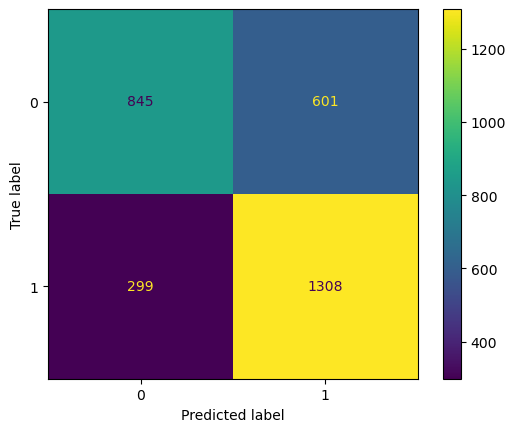

In [155]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, xgb_preds, labels=rf1.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rf1.classes_, 
                             )
disp.plot(values_format='');

The model is almost twice as likely to predict a false positive than it is to predict a false negative. Therefore, type I errors are more common. This is less desirable, because it's better for a driver to be pleasantly surprised by a generous tip when they weren't expecting one than to be disappointed by a low tip when they were expecting a generous one. However, the overall performance of this model is satisfactory. 

##### Feature importance

For simplicity, let's use the random forest model  to get the feature importance with the `feature_importances_` attribute of the best estimator object. We can then sort them and plot the most important ones.

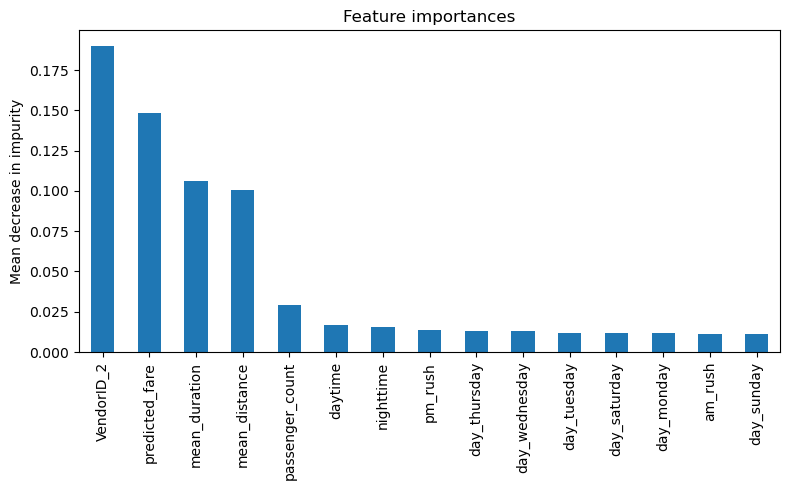

In [174]:
importances = rf1.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_test.columns)
rf_importances = rf_importances.sort_values(ascending=False)[:15]

fig, ax = plt.subplots(figsize=(8,5))
rf_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout();

### **Task 4. Conclusion**

In this step, we will use the results of the models above to formulate a conclusion. Let's consider the following questions:

1. **Would we recommend using this model? Why or why not?** 

Yes, this is model performs acceptably. Its F<sub>1</sub> score was 0.744 and it had an overall accuracy of 0.705. It may be worthwhile to test the model with a select group of taxi drivers to get feedback.

2. **What was the model doing? how was it making predictions?**   

We know that `VendorID`, `predicted_fare`, `mean_duration`, and `mean_distance` are the most important features, but we don't know how they influence tipping. This would require further exploration. It is interesting that `VendorID` is the most predictive feature. This seems to indicate that one of the two vendors tends to attract more generous customers. It may be worth performing statistical tests on the different vendors to examine this further

3. **Are there new features that we can engineer that might improve model performance?**  

There are almost always additional features that can be engineered, but hopefully the most obvious ones were generated during the first round of modeling. In our case, we could try creating three new columns that indicate if the trip distance is short, medium, or far. We could also engineer a column that gives a ratio that represents (the amount of money from the fare amount to the nearest higher multiple of \\$5) / fare amount. For example, if the fare were \\$12, the value in this column would be 0.25, because \\$12 to the nearest higher multiple of \\$5 (\\$15) is \\$3, and \\$3 divided by \\$12 is 0.25. The intuition for this feature is that people might be likely to simply round up their tip, so journeys with fares with values just under a multiple of \\$5 may have lower tip percentages than those with fare values just over a multiple of \\$5. We could also do the same thing for fares to the nearest \\$10.

$$
round5\_ratio = \frac{amount\ of\ money\ from\ the\ fare\ amount\ to\ the\ nearest\ higher\ multiple\ of\ \$5}{fare\ amount}
$$

4. **What features would you want to have that would likely improve the performance of your model?**   

It would probably be very helpful to have past tipping behavior for each customer. It would also be valuable to have accurate tip values for customers who pay with cash.
It would be helpful to have a lot more data. With enough data, we could create a unique feature for each pickup/dropoff combination.